# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)
11. "Monitoraggio settimanale - Ministero della Salute" check [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.
12. "Monitoraggio settimale" by Istituto Superiore di Sanità, detailed reports, [here](https://www.iss.it/monitoraggio-settimanale)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2022-02-11"
print(date_)

2022-02-18


In [4]:
pastdays='000'

## Rt gamma parameters:

In [5]:
alpha = 1.87
beta = 0.28

ALPHA=100.

## Load DPC data, smooth them and compute naive Rt

In [6]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999972526777009
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999916348011435
deceduti_giornalieri_smoothed

# Use RSVD: Regularized Singular Value Decomposition

RSVD allows to detect the seasonal component of the signal.

In the case of DPC `nuovi_positivi` we have a **weekly seasonality**, hence `season_period = 7`

RSVD has been proposed by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), in this [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)

It essentially casts the signal vector into a matrix whose columns are the seasons and the rows are the repetitive periods of a complete series of seasons. In our case the matrix shape will be `(~len(signal) / 7, 7)`.
Singular Value Decomposition is applied to the matrix so that singular values represent the seasonal component of the signal. Each (7 in our case) seasonal component is regularized via Tikhonov, following the hypotheis that each season component, period after period, must change smoothly. The Tikhonov regularization paramether is fitted via "leave one out cross validation".

The advantage of this method with respect to the SARIMA approach is that **we don't need to take moving averages**, and we don't need to tune any metaparameter of the model.

We wrote the python porting of the original R code.
The python porting is available from the following namespace:
```
import covid19_pytoolbox.smoothing.seasonalRSVD
```

The following features have been added to the original work:
- RSVD is applied by means of two different classes:
  - `SeasonalRegularizer` applies RSVD to the plain data
  - `LogSeasonalRegularizer` applies RSVD on the logarithm of the data to remove exponential trends; the inverse functions are correctly applied before returning the outputs, to remove the effects of taking the logarithm on the original signal
- both classes accept a `difference_degree` parameters; if greater then 0, the `n-th = difference_degree` difference is taken on the original signal prior to apply RSVD; this is helpful to remove non-stationarity in the original data
- the `adfuller` test can be performed on the input data to check (manually) if any non-stationary component is present
- the Tikhonov regularized trend is extracted from the deseasoned signal
- residuals are computed as differences between the deseasoned signal and the smoothed trend; relative residuals are also computed by the `LogSeasonalRegularizer`
- the signal is left truncated to obtain the RSVD matrix; before returning, the outputs are padded with `np.nan` to the left, to rebuild the original vector shape


In [7]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

[   'nuovi_positivi',
    'tamponi_giornalieri',
    'nuovi_ospedalizzati',
    'deceduti_giornalieri',
    'ingressi_terapia_intensiva']
nuovi_positivi_deseason
info_cri:  -2.1512383946836073
info_cri:  -2.056485470938278
TIC R2: 0.993660088019867
patterns: 1
(   -7.940396842351208,
    3.3258850391505953e-12,
    20,
    705,
    {   '1%': -3.4396596024765795,
        '10%': -2.568957779286756,
        '5%': -2.86564834926679},
    -489.51283528328645)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.1709322812080263
info_cri:  -2.008265700638118
TIC R2: 0.9831968063365514
patterns: 1
(   -10.35121532252875,
    2.5338324095999263e-18,
    20,
    705,
    {   '1%': -3.4396596024765795,
        '10%': -2.568957779286756,
  

## Plotting the signal after applying RSVD

- the blue line is the original signal
- the violet line represent the oscillating seasonal component
- the orange line is the deseasoned signal
  - we can see how the orange line is much less oscillating with respect to the blue one, as RSVD succeded in removing the seasonal component
- the red line represents the smoothed trend of the deseasoned signal

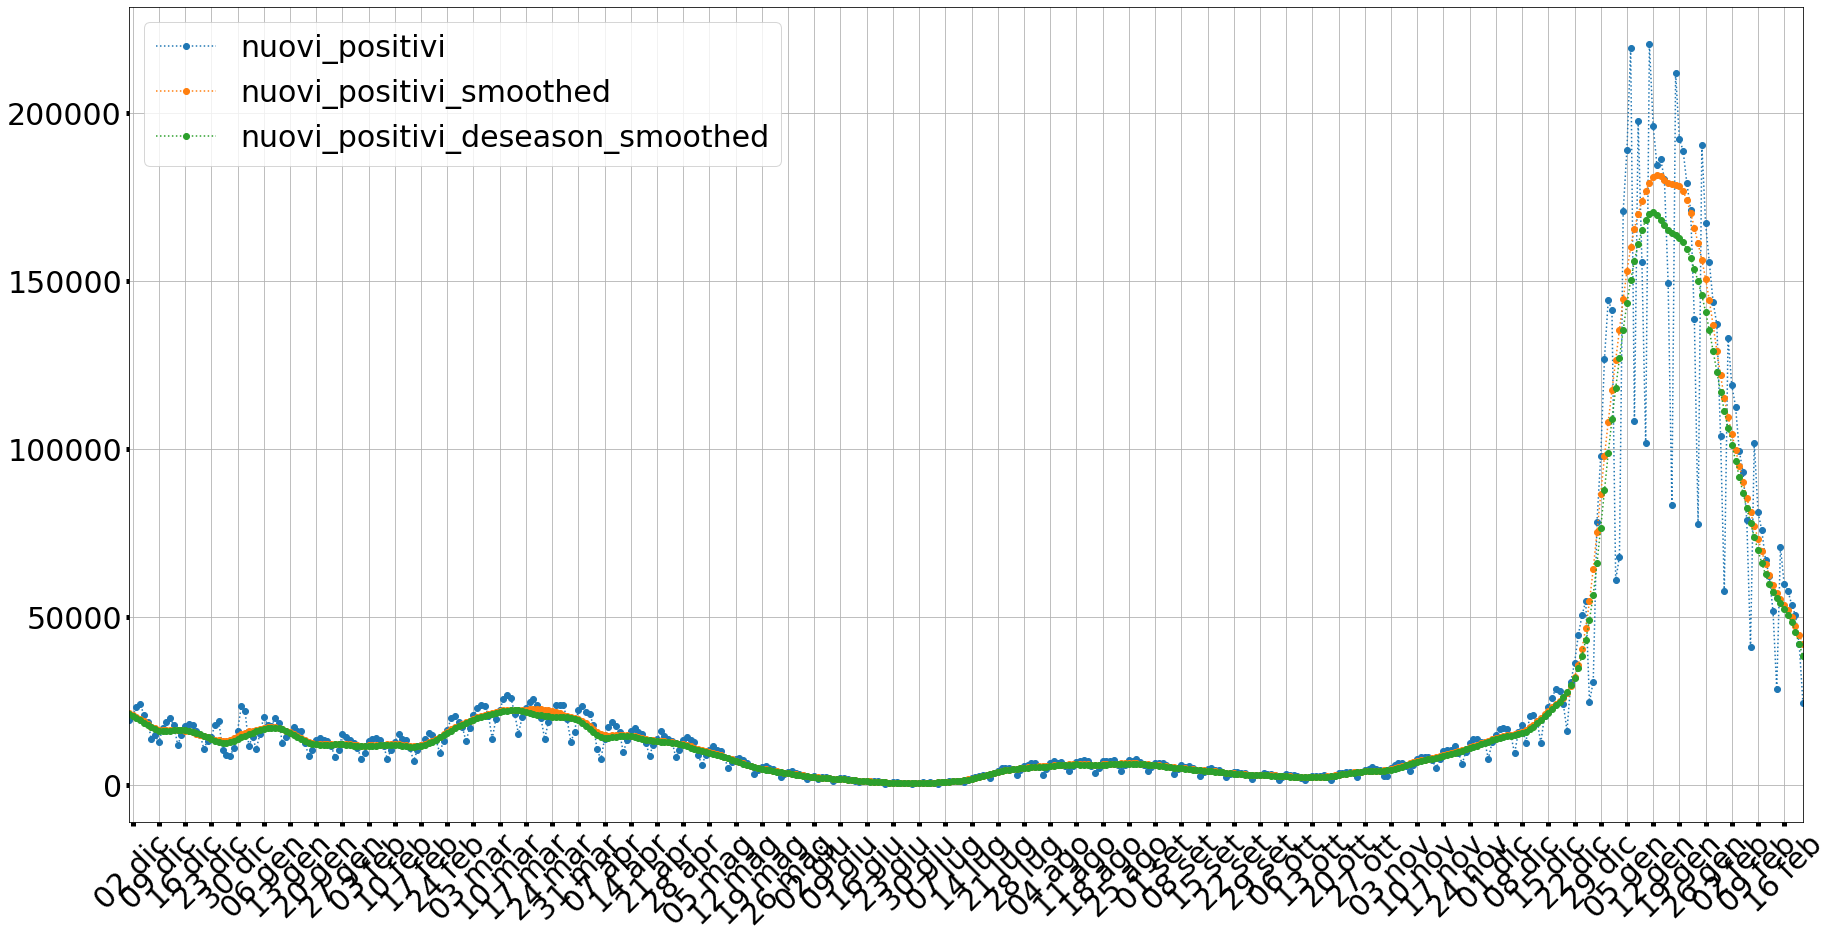

In [8]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

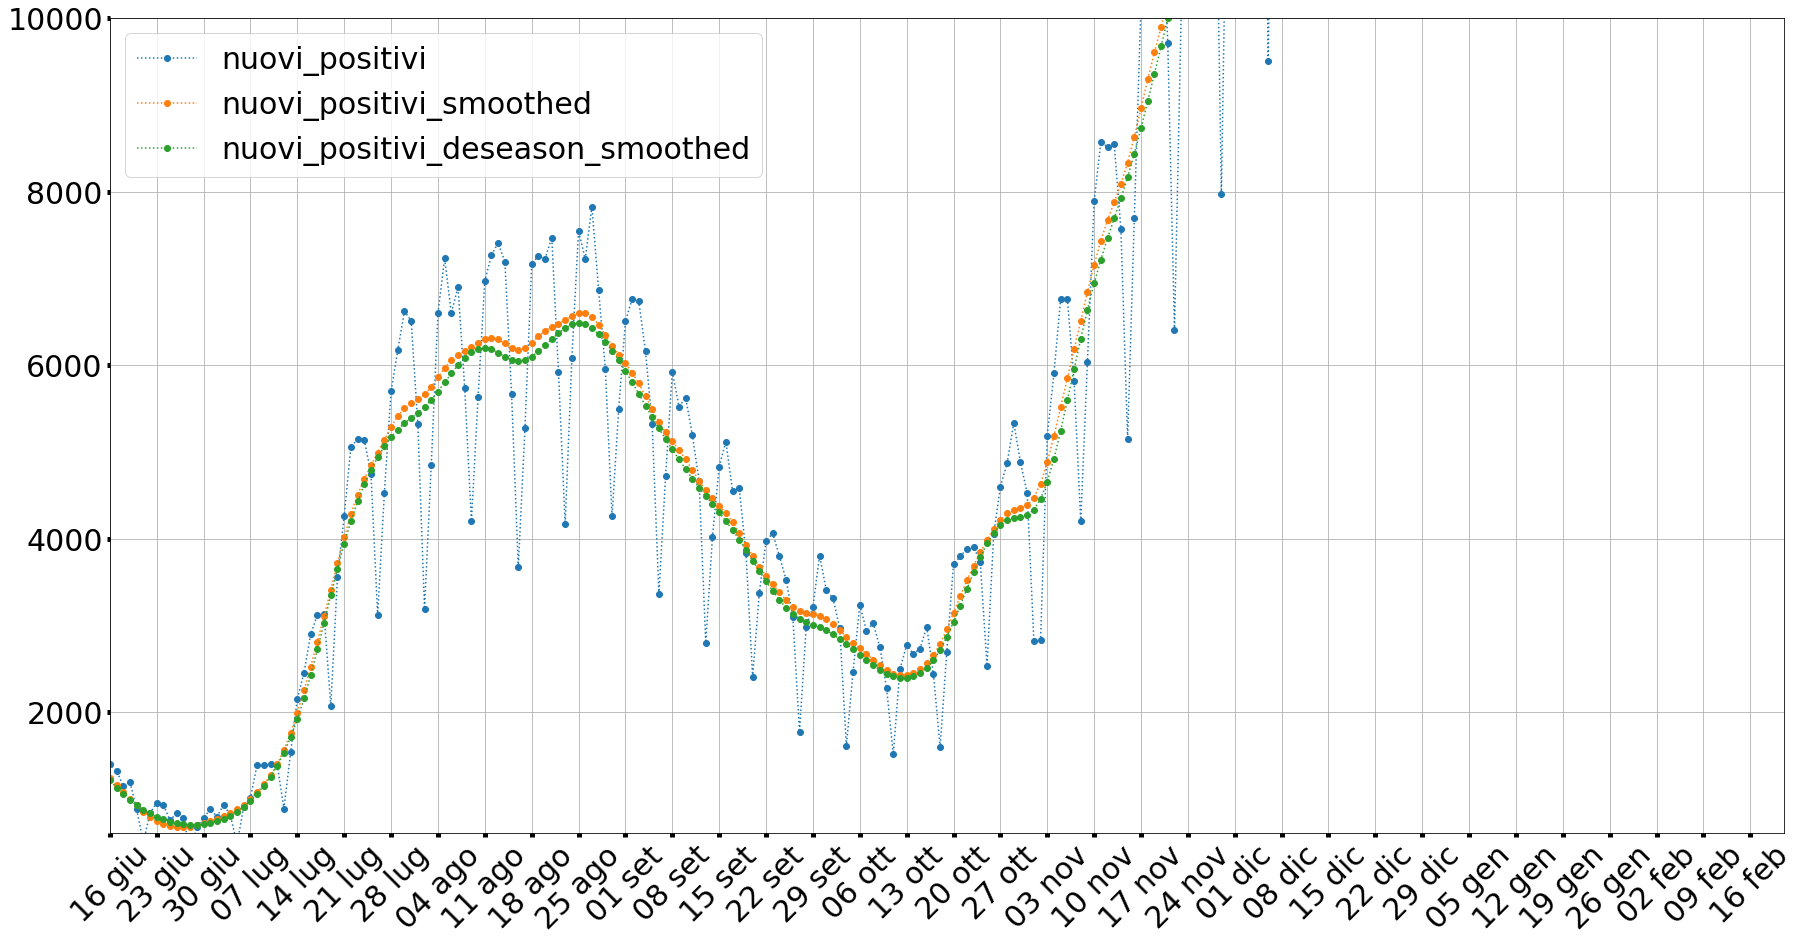

In [9]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    ylim=(600,10000),
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

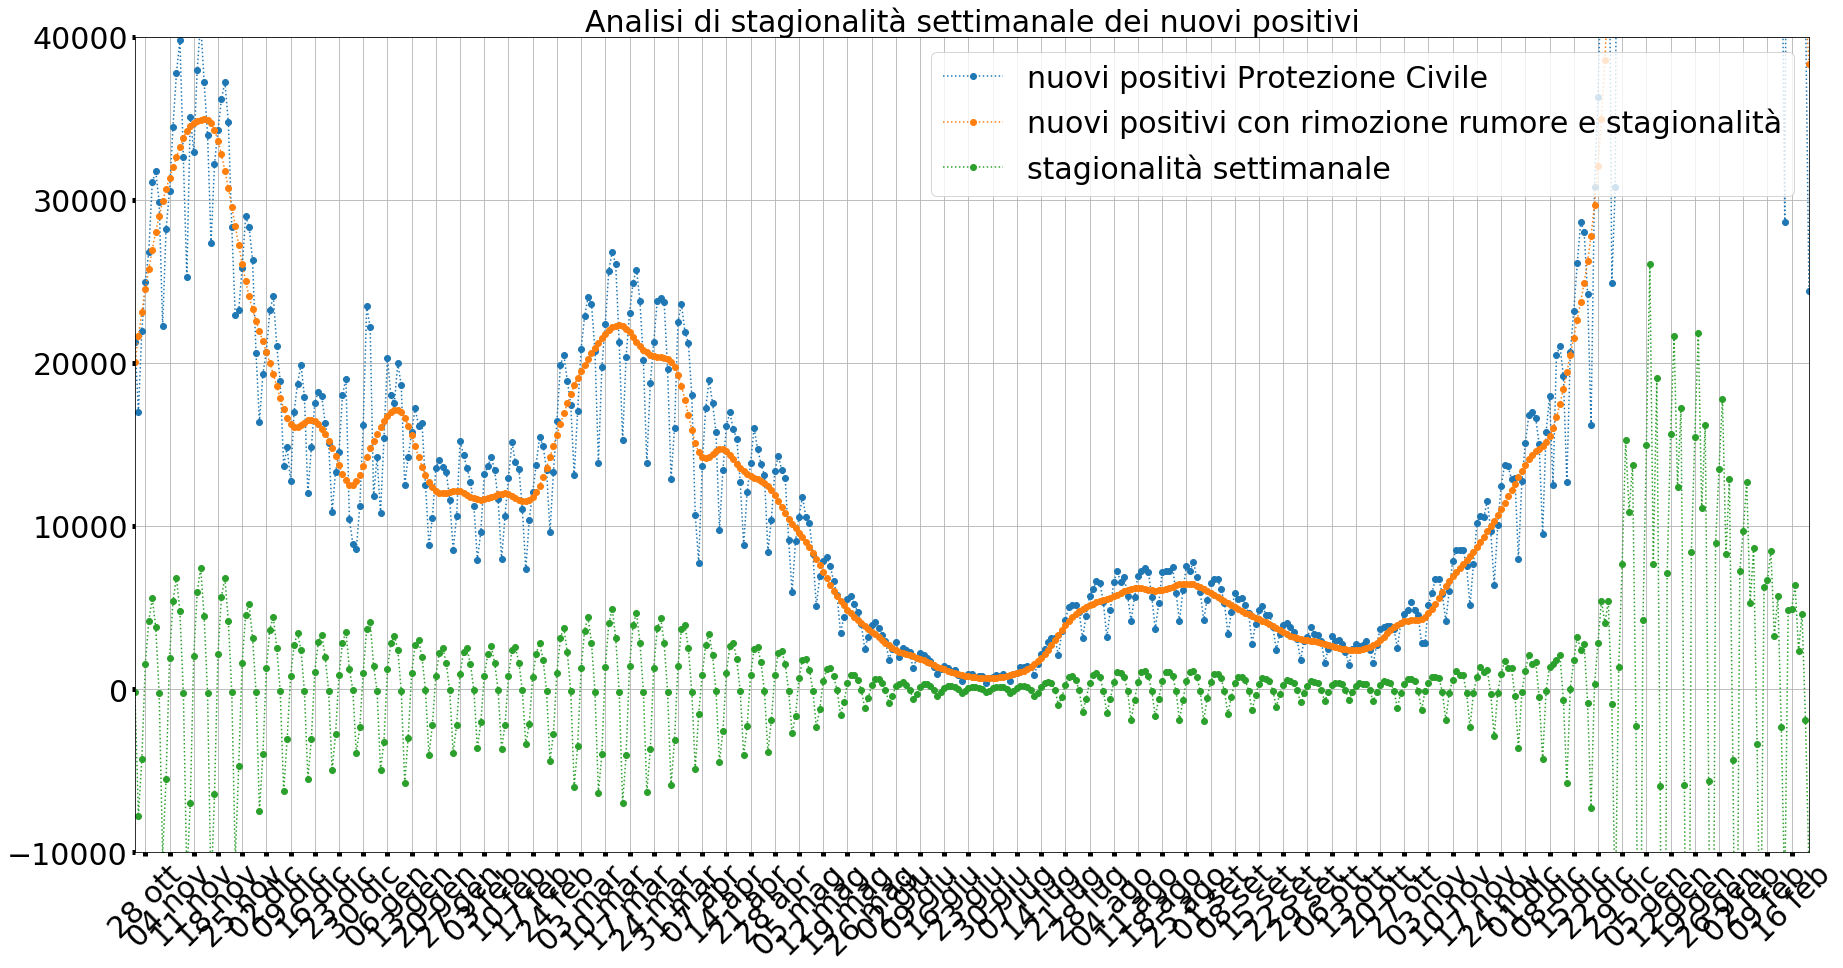

In [10]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right"
)

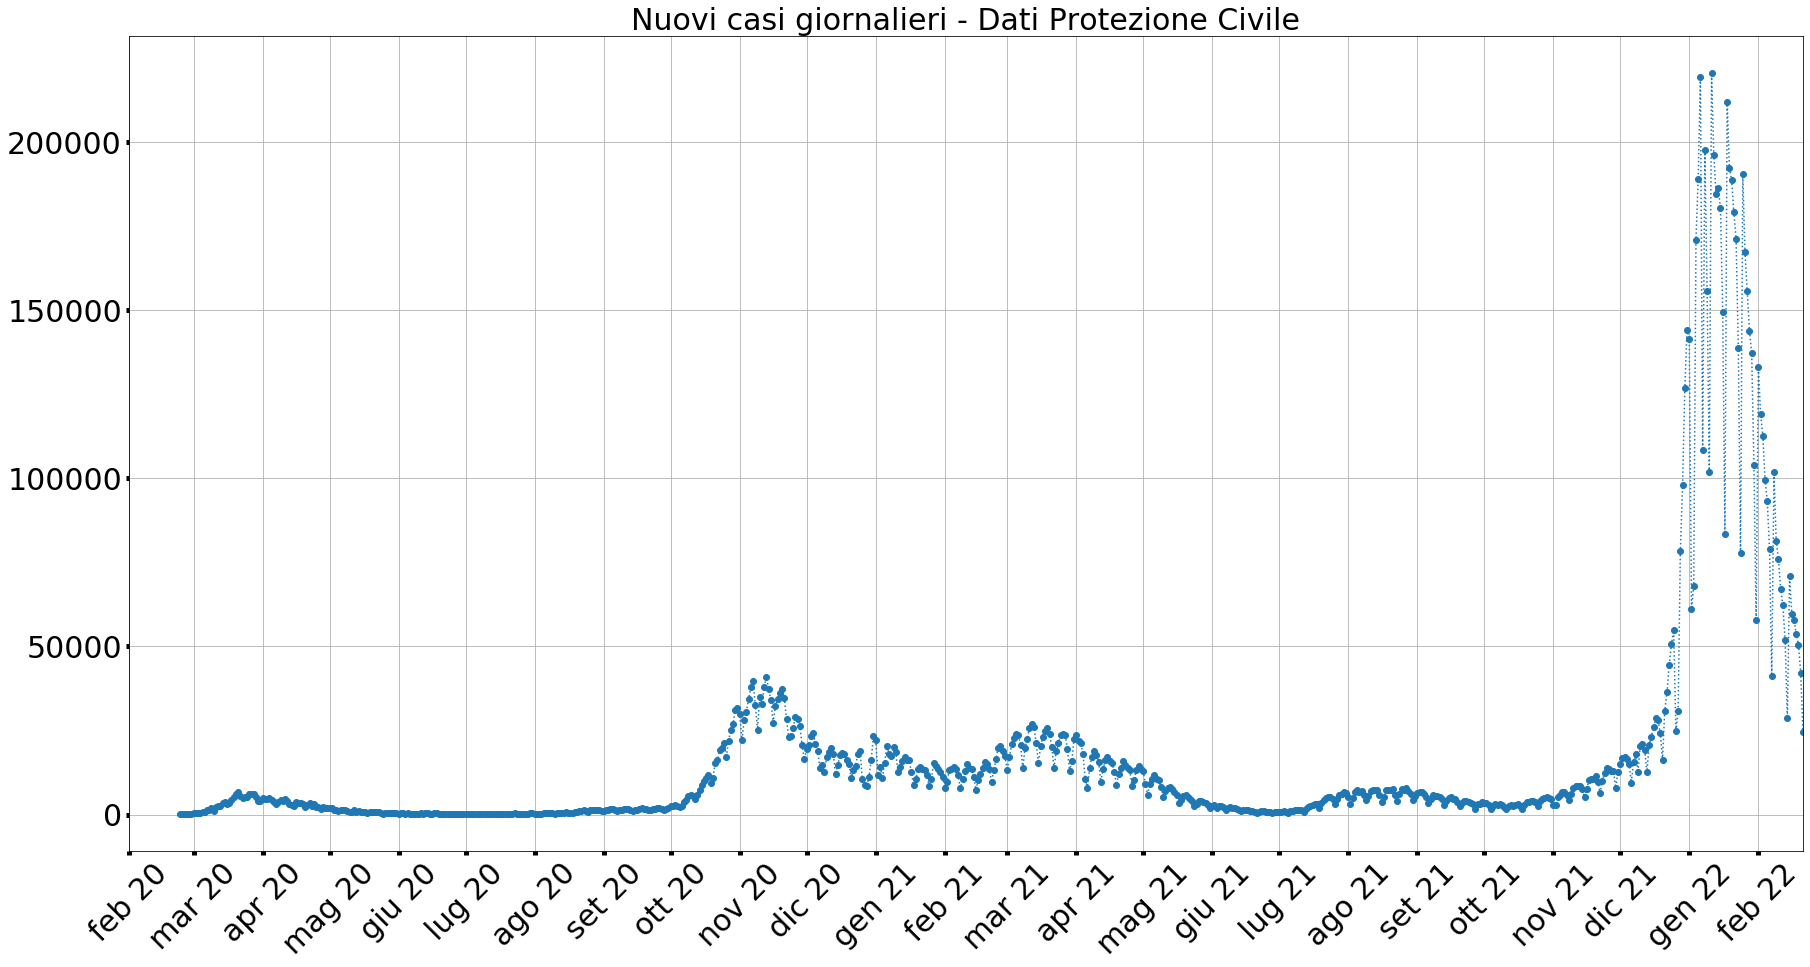

In [11]:
plotting.plot_series(
    title='Nuovi casi giornalieri - Dati Protezione Civile',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,2,1), DPC_data.data.max()),
#    ylim=(-10000,40000),
#    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right",
    major_formatter=mdates.DateFormatter("%b %y"),
    major_locator=mdates.MonthLocator(bymonthday=1),
    legend_on=False
)

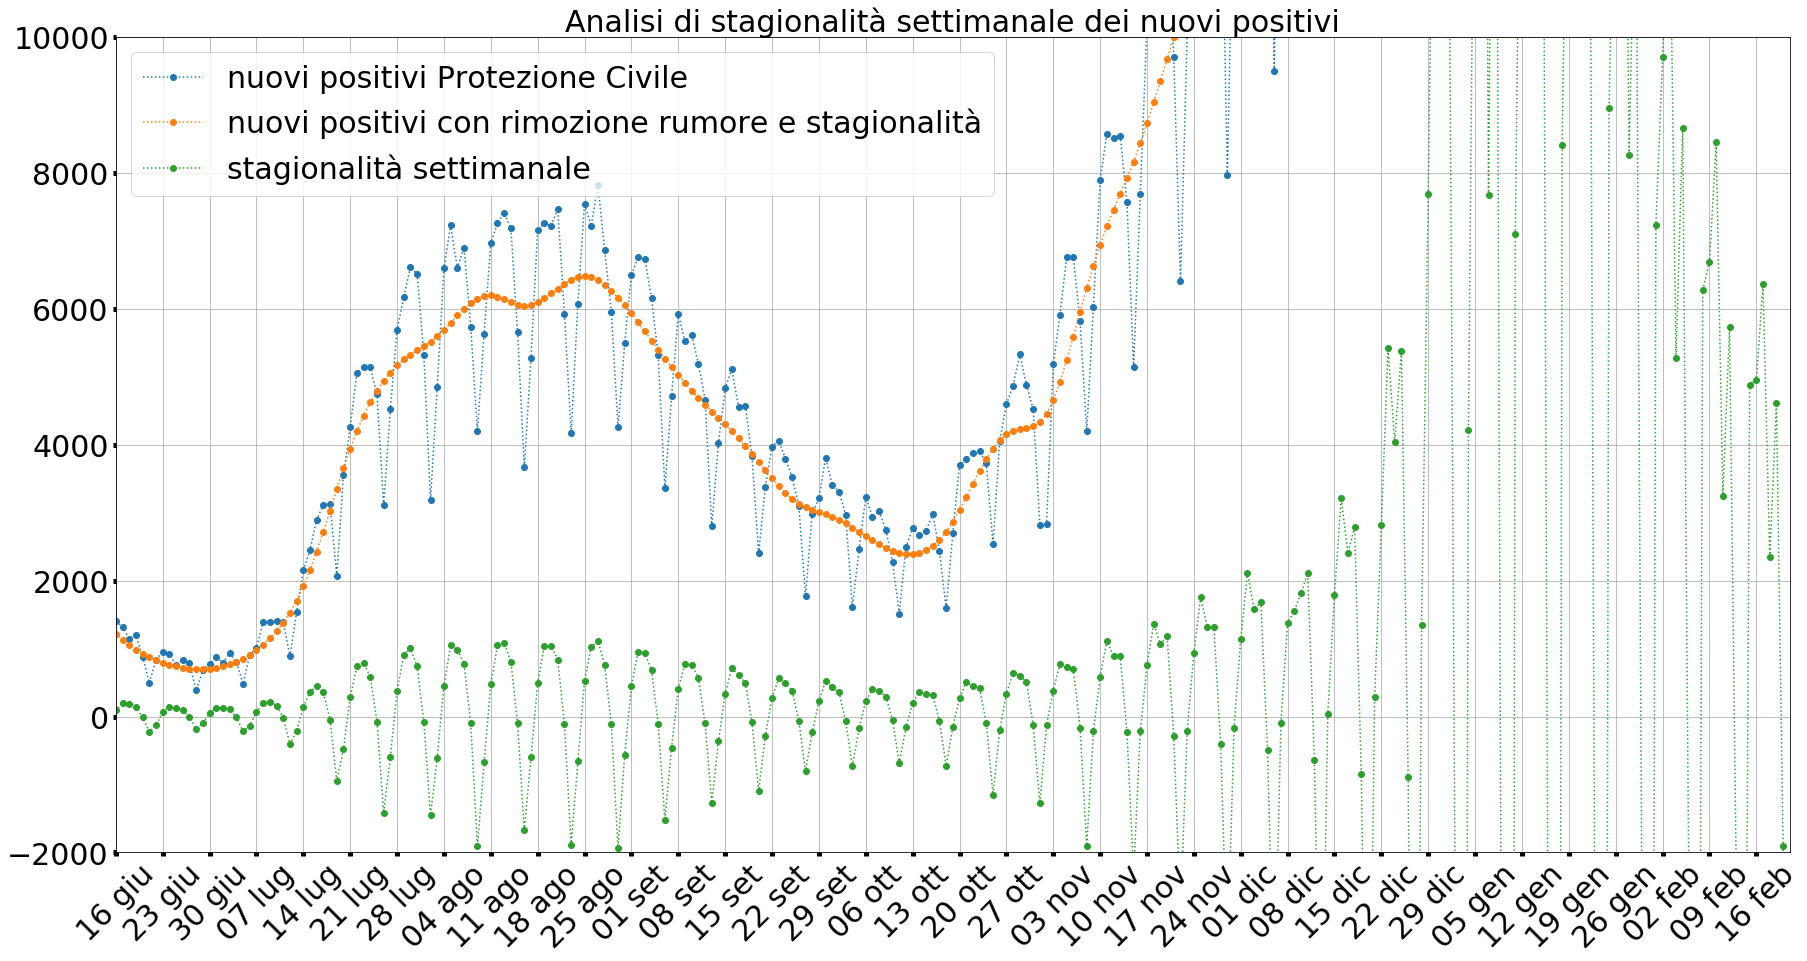

In [12]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    ylim=(-2000,10000),
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper left"
)

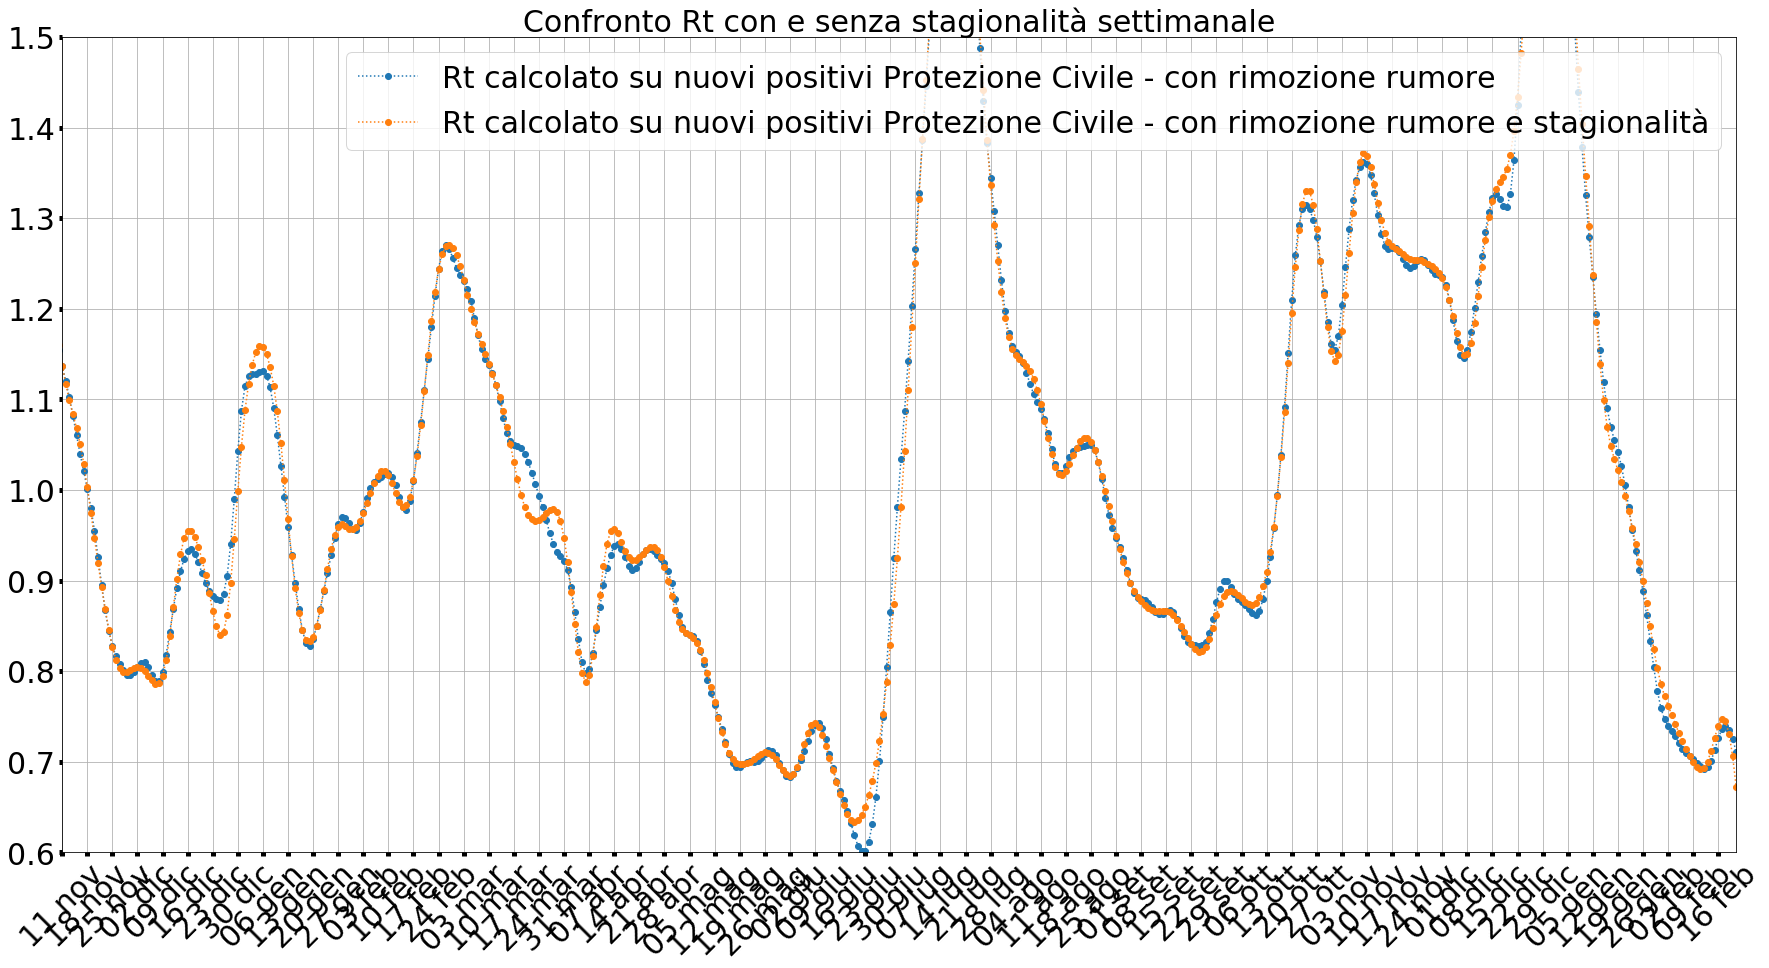

In [13]:
plotting.plot_series(
    title='Confronto Rt con e senza stagionalità settimanale',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_smoothed_Rt',
            'nuovi_positivi_deseason_smoothed_Rt', 
        ],
        'labels':[
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore',
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore e stagionalità',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(0.6,1.5),
    legend_loc="upper right"
)

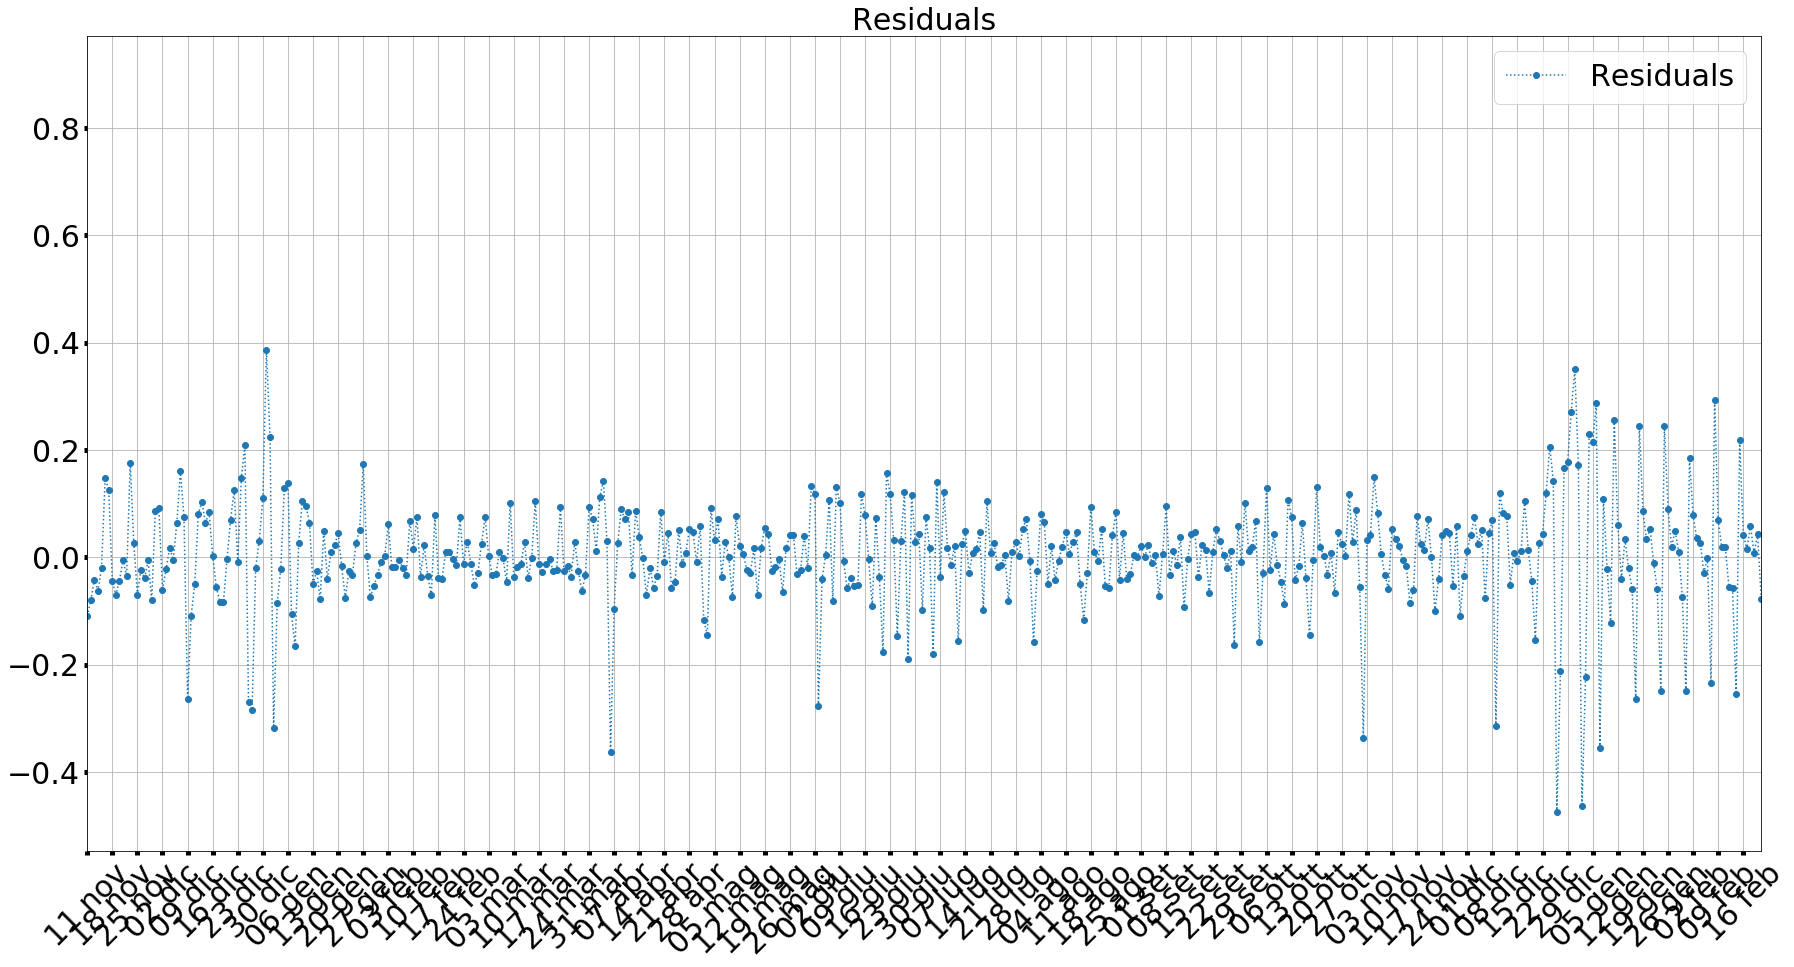

In [14]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

## Distribution of residuals

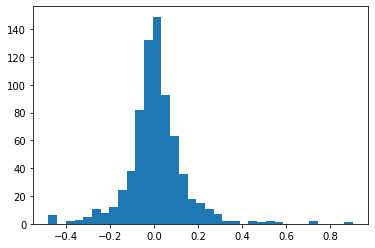

In [15]:
_=plt.hist(DPC_data.nuovi_positivi_deseason_relative_residuals,bins=35)

# Predict the next value of new cases

From the base formula for $R_t$:
$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

we can compute the next $I_{t+1}$ value, given $R_{t+1}$:

$$\large{{I_{t+1}} = R_{t+1} \times {\sum_{s=1}^{t+1} w_s I_{t+1-s}}}$$

$$s'=s-1$$

$$\large{{I_{t+1}} = R_{t+1} {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

Using Taylor to expand $R_{t+1}$:

$$R(t+dt) = R(t) + dR(t)dt + \frac{1}{2} d^2R(t) dt^2$$
$$R(t+\Delta t) = R(t) + \Delta R(t)\Delta t + \frac{1}{2} \Delta^2R(t) \Delta t^2$$
$$\Delta t = 1$$
$$R(t+1) = R(t) + [R(t)-R(t-1)] + \frac{1}{2} [R(t)-R(t-1)-(R(t-1)-R(t-2))]$$
$$ = 2R(t)-R(t-1) + \frac{1}{2} [R(t)-2R(t-1)+R(t-2)]$$
$$ = \frac{3}{2} R(t) - 2 R(t-1) +\frac{1}{2} R(t-2)$$

We finally have:
$$\large{{I_{t+1}} = \left[\frac{3}{2} R_t - 2 R_{t-1} +\frac{1}{2} R_{t-2} \right] {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

# Obtain the confidence interval from the predictions

$$\large{X_t = S_t + E_t}$$

where:
- $X$ is the original signal
- $S$ is the seasonal component
- $E$ is the deseasoned component

$$\large{E_t = T_t + \epsilon_t}$$

where:
- $T$ is the smoothed trend
- $\epsilon$ is the residual

$$\large{X_{t+1}= T_{t+1} + \epsilon_{t+1} + S_{t+1}}$$

where we can approximate $X_{t+1}$ with the following:
- $T_{t+1}$ is approximated via Taylor on the previous $R_t$ knowledge
- $\epsilon_{t+1}$ is sampled from a gaussian distribution of the relative residuals, with $\mu=AVG_{t-7}(\epsilon_t/T_t)$ and $\sigma=STD_{t-7}(\epsilon_t/T_t)$

- $S_{t+1}$ is approximated with taylor from the last $S_{t+1-period}$ known value

## Strategy:

1. deseason once and obtain $T, R, S$
2. with those sample multiple values of $X_{t+1}$ based on taylor expantion and the hypotesis that tomorrow new cases can range from `0.8` to `1.2` as many the cases of today, as from $T$
3. generate multiple possible series $X^i$ with $i$ spanning the samples
4. deseason again each of the possible series
5. drop the last value as it is tomorrow
6. use the obtained $T$ as the truth value for the posterior in MCMC, adding noise sampled from $\epsilon_t$

This strategy is implemented essentially in two functions:

#### `covid19_pytoolbox.modeling.datarevision.seasonal.draw_expanded_series`:
`draw_expanded_series` performs steps 1 to 4, with as many `draws` future scenario


#### `covid19_pytoolbox.modeling.Rt.bayesian.MCMC_sample`:
`MCMC_sample` perform step 6, by sampling $R_t$ and $\epsilon_t$  in 4 chains with 500 samples each, forcing the number of new cases to be Bernoulli distributed with respect to the trend $T$.

By iterating `MCMC_sample` on each draw from the previous steps, the method can accounts for data revision, as each draw is a possibile future scenario ranging from `0.8` to `1.2` wrt the current trend $T$.

In [16]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [17]:
# set the following to anything grater than 0 to compute Rt series based on past days values on new cases
# this is helpful in checking how the method is robust against data revision

PASTDAYS_BEGIN=0

draws = 5

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):

    if pastdays == 0:
        sl = np.s_[:]
    else:
        sl = np.s_[:-pastdays]
        
    new_cases = DPC_data.nuovi_positivi.to_numpy()[sl]
    
    new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            alpha=alpha, beta=beta, truncate=False
        )
        
    new_cases_smoothed, rel_eps, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=100.,difference_degree=2)
        
    simulations = []
    for new_cases_s, rel_eps_s in zip(new_cases_smoothed, rel_eps):        
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps_s[~np.isnan(rel_eps_s)],
            eps_window=1,
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        DPC_data, 'nuovi_positivi_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1)

    
    DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [18]:
italy_calc_data = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{date_}_futbound_08_12_National_MCMC_Rt_pastdays_{pastdays}_{pastdays}.pickle')
)

In [19]:
italy_calc_data.sort_values(by='data', inplace=True)
italy_calc_data.reset_index(drop=True, inplace=True)

## Save computed data to csv and excel

In [20]:
procdata_to_save = italy_calc_data.loc[
    italy_calc_data.data>"2020-03-01",
    [
        "data", 
        "nuovi_positivi",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}"
    ]
].sort_values(by="data", ascending=False)

procdata_to_save.rename(columns={
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}": "Rt",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}": "Rt_interv_cred_min",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}": "Rt_interv_cred_max",
}, inplace=True)

procdata_to_save.to_csv(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.csv"),
    float_format='%.2f',
    index=False
)
procdata_to_save.to_excel(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.xlsx"),
    float_format='%.2f',
    index=False        
)

# ISS Data

To allow for comparison with official $Rt$ calculation, we load official data from a static dataset which we update manually every week.

In [21]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
75,2021-12-29,2022-01-11,1.31,1.00,1.83,0.52,0.31,2022-01-04 23:59:00
76,2022-01-05,2022-01-18,0.97,0.86,1.18,0.21,0.11,2022-01-11 23:59:00
77,2022-01-12,2022-01-25,0.93,0.90,0.98,0.05,0.03,2022-01-18 23:59:00
78,2022-01-19,2022-02-01,0.89,0.79,1.02,0.13,0.10,2022-01-25 23:59:00
79,2022-01-26,2022-02-08,0.77,0.72,0.88,0.11,0.05,2022-02-01 23:59:00


In [22]:
def plot_simulation_results(
    simdf, ISSdf, xmin=datetime(2020,7,25), xmax=None, ylim=(0.2,2.5), 
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'TD_Rt_computation_MCMC_300dpi')):
    
    if not xmax:
        xmax = simdf.data.max()
        
    plotting.plot_series(
        title='',
        message='Aggiornamento del {}'.format(xmax.strftime('%d %b %Y')),
        data=[
            {
                'df': ISSdf,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
                'colors': ['blue']
            },        
            {
                'df': simdf,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
                ],
                'labels': [
                    f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=27,
        xlim=(xmin, xmax),
        ylim=ylim,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60,
        tick_fontsize=20,
        major_formatter=mdates.DateFormatter("%d %b %y")
    )

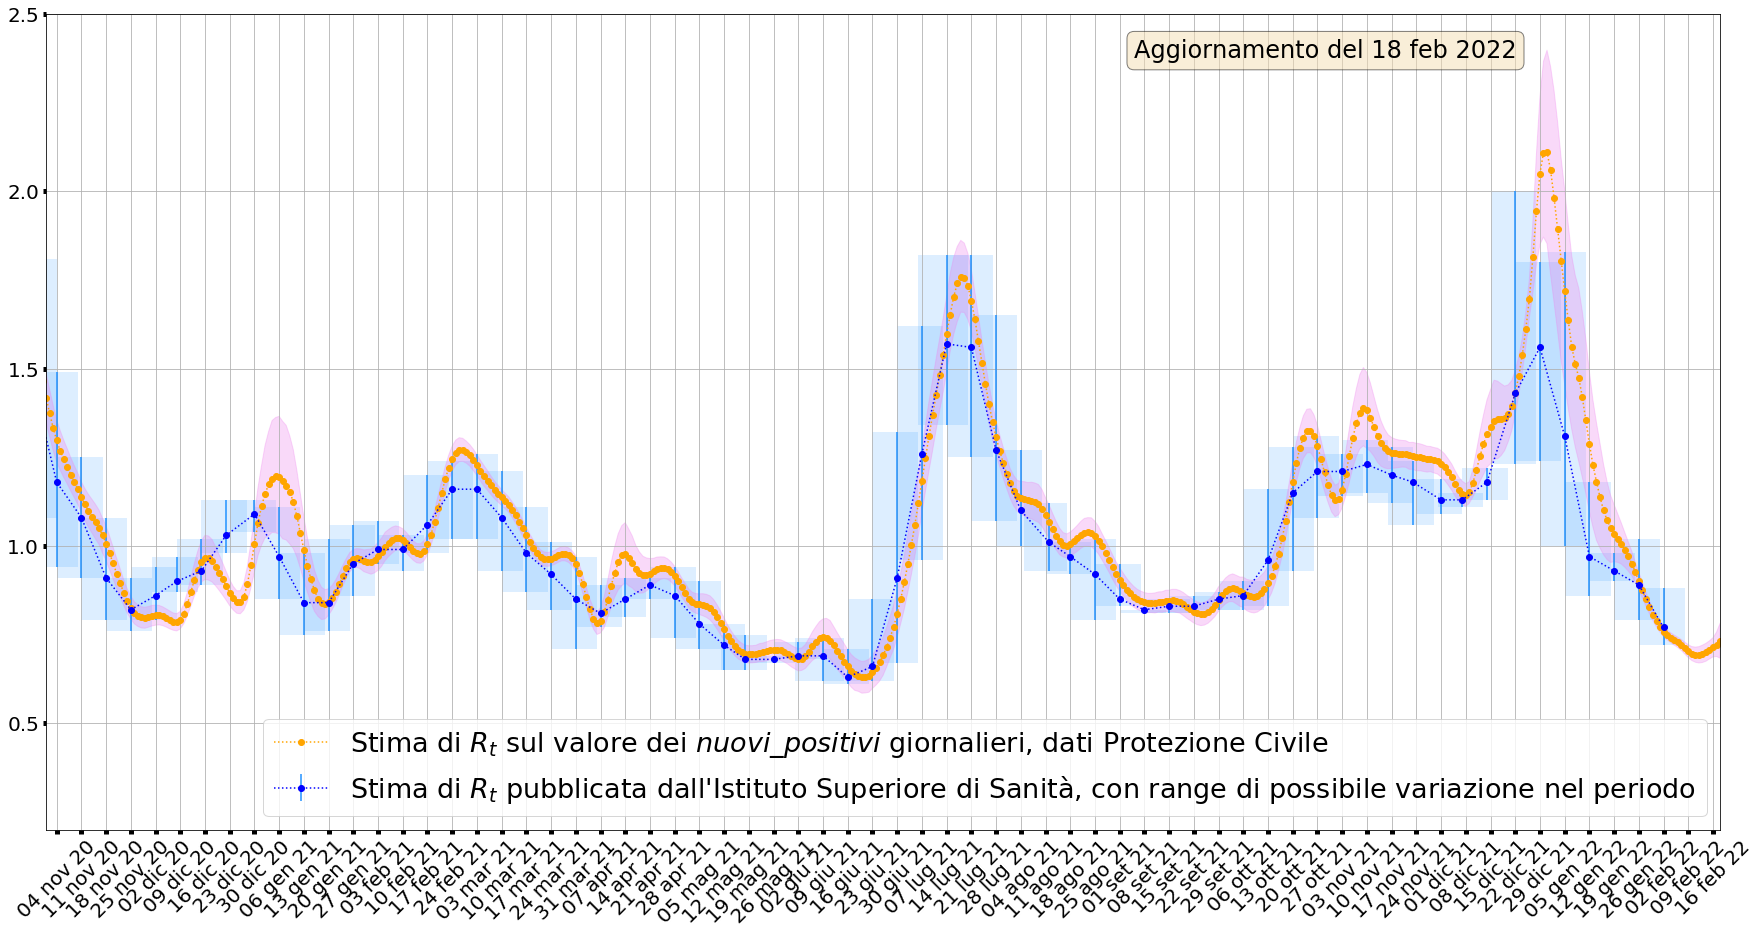

In [23]:
plot_simulation_results(
    simdf=italy_calc_data, ISSdf=ISS_Rt_clean, xmin=datetime(2020,11,1)) #, xmax=datetime(2021,11,26)

In [24]:
italy_calc_data.loc[italy_calc_data.data>'2021-01-01',['nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000']].min()

nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000    0.629441
dtype: float64

In [25]:
italy_calc_data['nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000'][100]

0.6201829697093836

In [26]:
italy_calc_data.set_index("data").tail().T

data,2022-02-14,2022-02-15,2022-02-16,2022-02-17,2022-02-18
stato,ITA,ITA,ITA,ITA,ITA
ricoverati_con_sintomi,16050,15602,15127,14562,13948
terapia_intensiva,1173,1119,1073,1037,987
totale_ospedalizzati,17223,16721,16200,15599,14935
isolamento_domiciliare,1573392,1533689,1463913,1422609,1389187
totale_positivi,1590615,1550410,1480113,1438208,1404122
variazione_totale_positivi,-48058,-40205,-70297,-41905,-34086
nuovi_positivi,28630,70852,59749,57890,53662
dimessi_guariti,10392540,10503380,10633268,10732908,10820380
deceduti,151296,151684,151962,152282,152596


In [27]:
italy_calc_data.tail(10)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,imported,total,imported_ratio,imported_ratio_avg14,imported_ratio_std14,imported_ratio_shifted,nuovi_positivi_corrected,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000
716,2022-02-09,ITA,17932,1350,19282,1855343,1874625,-53175,81367,9822915,...,NaN,NaN,NaN,NaN,NaN,0.000754,81305.674254,0.703372,0.685006,0.721392
717,2022-02-10,ITA,17354,1322,18676,1794598,1813274,-61351,75861,9960136,...,NaN,NaN,NaN,NaN,NaN,0.000754,75803.824088,0.696390,0.676746,0.716182
718,2022-02-11,ITA,16824,1265,18089,1733036,1751125,-62149,67152,10089429,...,NaN,NaN,NaN,NaN,NaN,0.000754,67101.388001,0.692578,0.671949,0.714639
719,2022-02-12,ITA,16310,1223,17533,1678081,1695614,-55511,62231,10206892,...,NaN,NaN,NaN,NaN,NaN,0.000754,62184.096925,0.692289,0.669885,0.715931
720,2022-02-13,ITA,16060,1190,17250,1621423,1638673,-56941,51959,10315987,...,NaN,NaN,NaN,NaN,NaN,0.000754,51919.838860,0.695182,0.671151,0.720095
721,2022-02-14,ITA,16050,1173,17223,1573392,1590615,-48058,28630,10392540,...,NaN,NaN,NaN,NaN,NaN,0.000754,28608.421767,0.700149,0.674853,0.725282
722,2022-02-15,ITA,15602,1119,16721,1533689,1550410,-40205,70852,10503380,...,NaN,NaN,NaN,NaN,NaN,0.000754,70798.599337,0.706323,0.681232,0.732307
723,2022-02-16,ITA,15127,1073,16200,1463913,1480113,-70297,59749,10633268,...,NaN,NaN,NaN,NaN,NaN,0.000754,59703.967591,0.713540,0.687091,0.741114
724,2022-02-17,ITA,14562,1037,15599,1422609,1438208,-41905,57890,10732908,...,NaN,NaN,NaN,NaN,NaN,0.000754,57846.368707,0.721690,0.688173,0.756719
725,2022-02-18,ITA,13948,987,14935,1389187,1404122,-34086,53662,10820380,...,NaN,NaN,NaN,NaN,NaN,0.000754,53621.555321,0.730465,0.683377,0.781898


# compare $R_t$ and new admissions

In [28]:
# this does not work until upgrading pandas to 1.3.5

#ISS_XLSX_FILE=os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2022-01-18T22:37:04+00:00.xlsx')
#SHEET = "ricoveri"
#fxlsx = pd.ExcelFile(ISS_XLSX_FILE,engine="openpyxl")
#if SHEET in fxlsx.sheet_names:
#    ricoveri = pd.read_excel(ISS_XLSX_FILE, sheet_name=SHEET, engine="openpyxl")


In [29]:
ricoveri = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2022-02-21T22:34:26+00:00.ricoveri.csv'),
    #parse_dates=['iss_date', 'DATARICOVERO1']
)

ricoveri.loc[ricoveri.RICOVERI=='<5',['RICOVERI']]=5
ricoveri.RICOVERI = ricoveri.RICOVERI.astype(int)
ricoveri.dropna(inplace=True)

ricoveri['data']= pd.to_datetime(
    ricoveri.DATARICOVERO1,
    format='%d/%m/%Y'
)

ricoveri.sort_values(by='data', inplace=True)
ricoveri.reset_index(drop=True, inplace=True)


In [30]:
ricoveri_stable = ricoveri.loc[ricoveri.data<"2022-02-14"].copy()

RSVD_smooth_data_generic(
    ricoveri_stable, ['RICOVERI'], 
    alpha, beta, 
    season_period=7, trend_alpha=100, difference_degree=4)

['RICOVERI']
RICOVERI_deseason
info_cri:  -1.0138816171122118
info_cri:  -0.1547666189328385
TIC R2: 0.9953430906660196
patterns: 1
(   -16.28378757985828,
    3.39149346964275e-29,
    20,
    696,
    {   '1%': -3.4397804336105198,
        '10%': -2.5689861435625576,
        '5%': -2.865701589065464},
    -906.8649699951739)
new columns generated:
[   'RICOVERI_deseason',
    'RICOVERI_deseason_seasonality',
    'RICOVERI_deseason_smoothed',
    'RICOVERI_deseason_residuals',
    'RICOVERI_deseason_relative_residuals',
    'RICOVERI_deseason_smoothed_Rt']


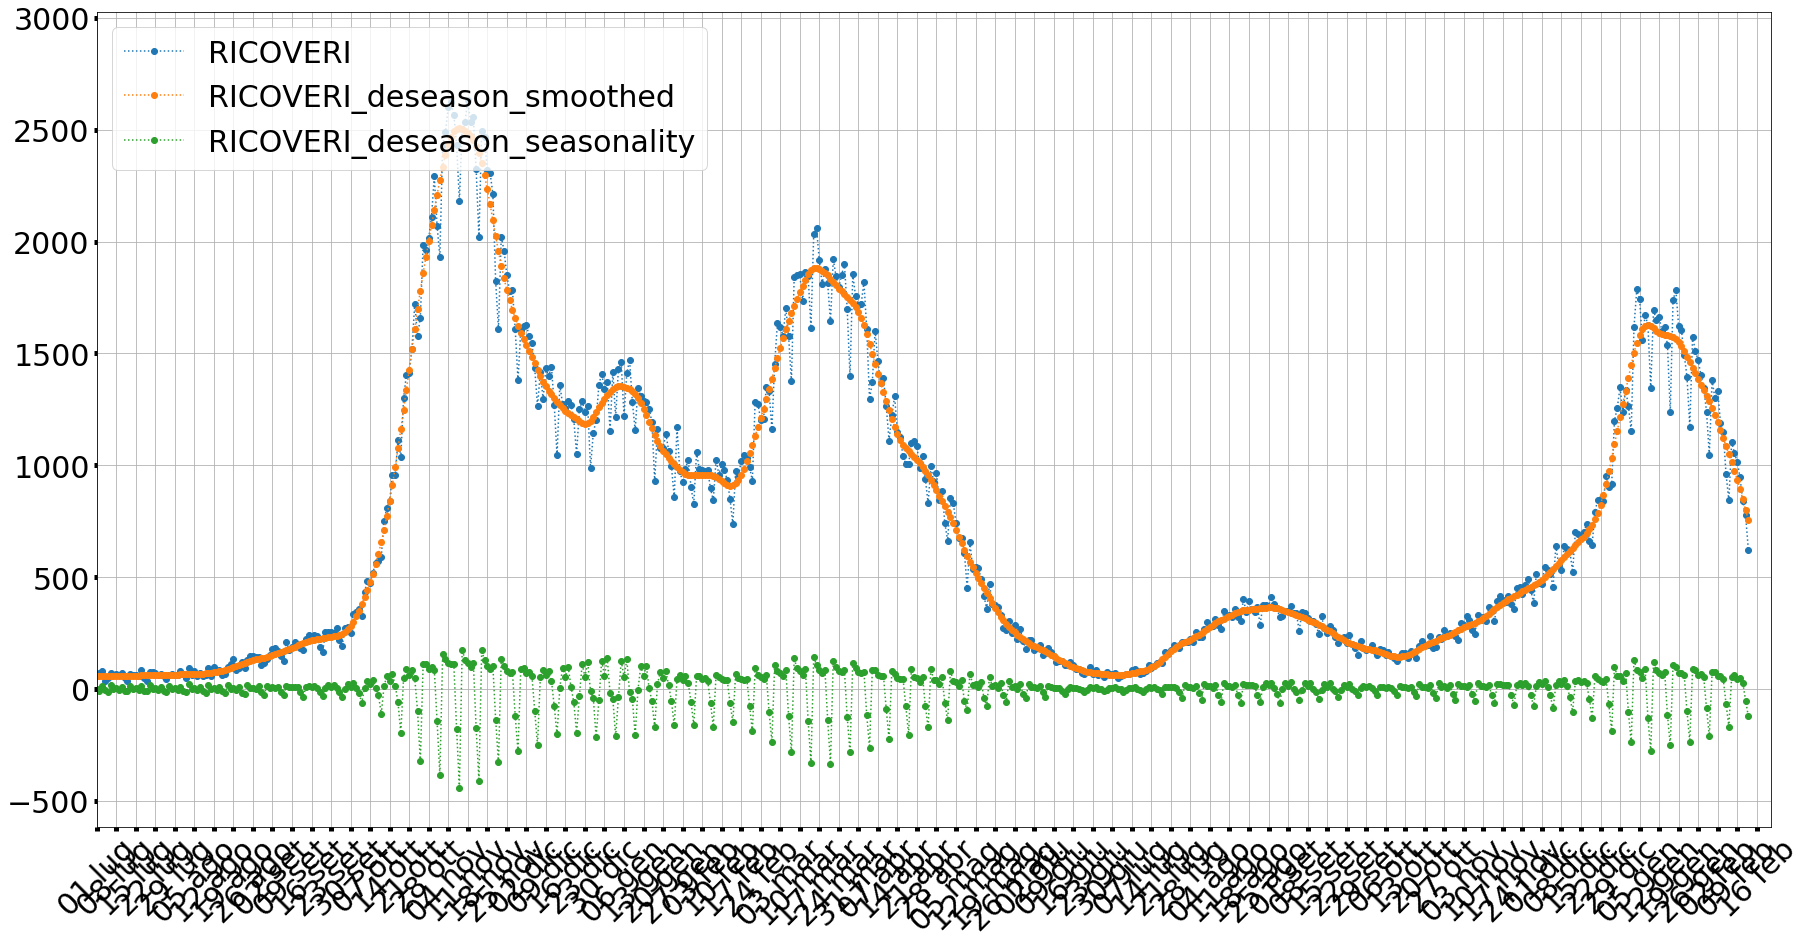

In [31]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

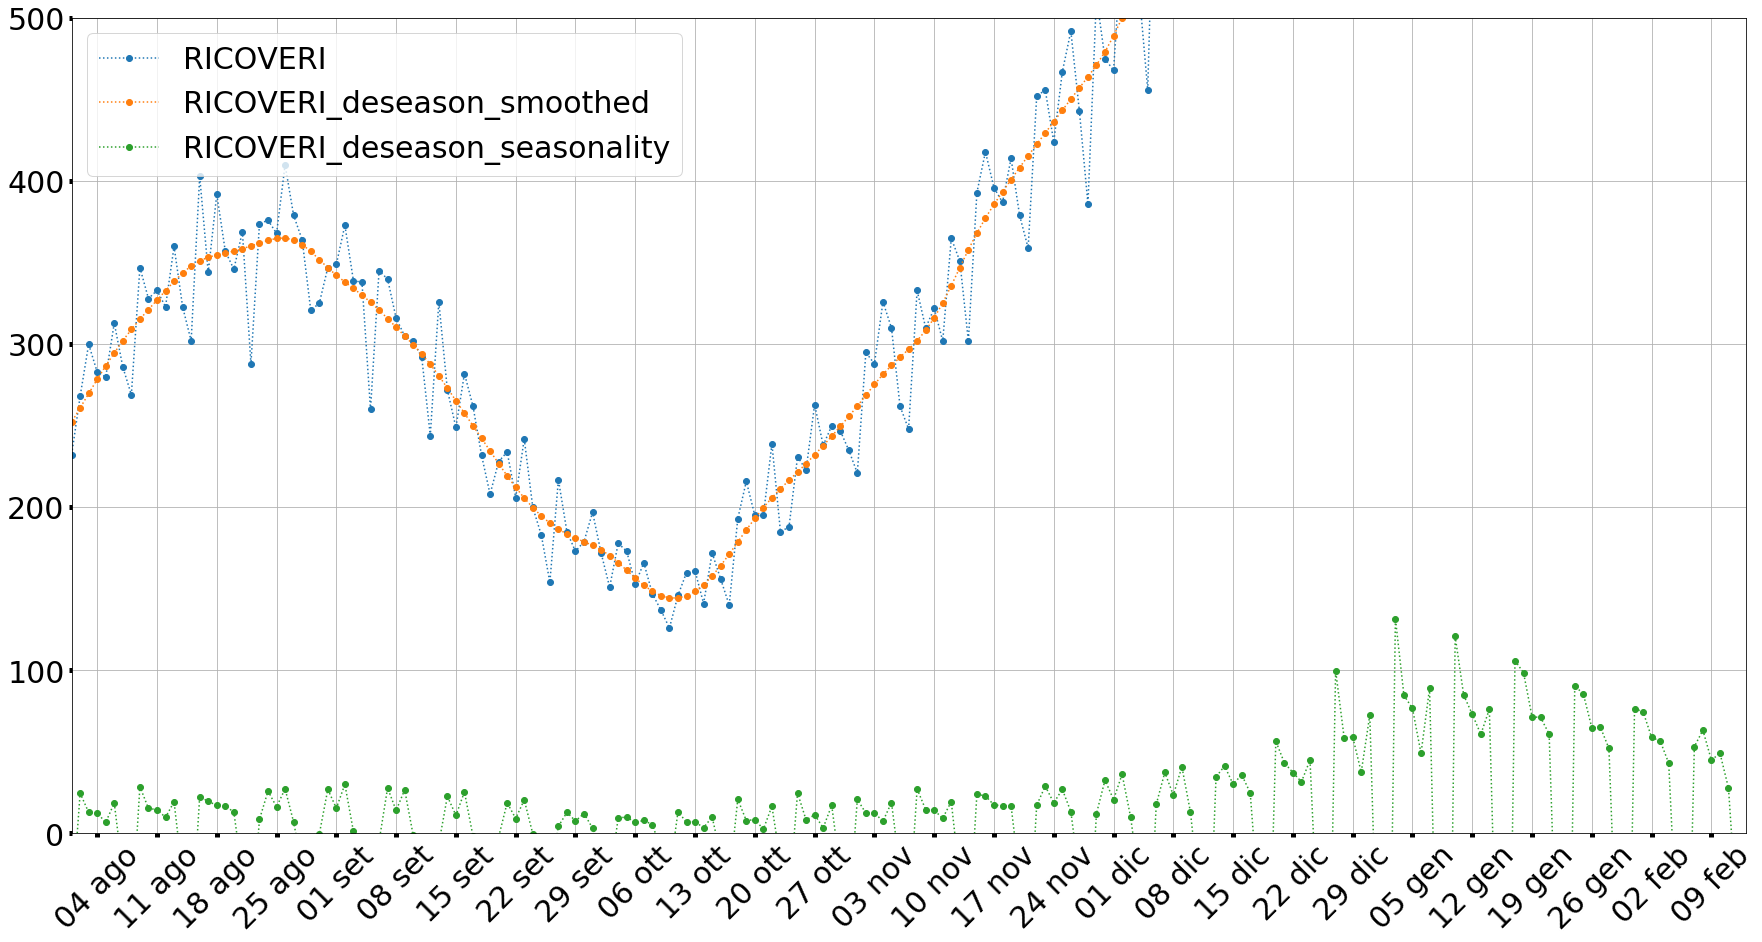

In [32]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    xlim=(datetime(2021,8,1), ricoveri_stable.data.max()),
    ylim=(0,500),
    legend_loc="upper left"
)

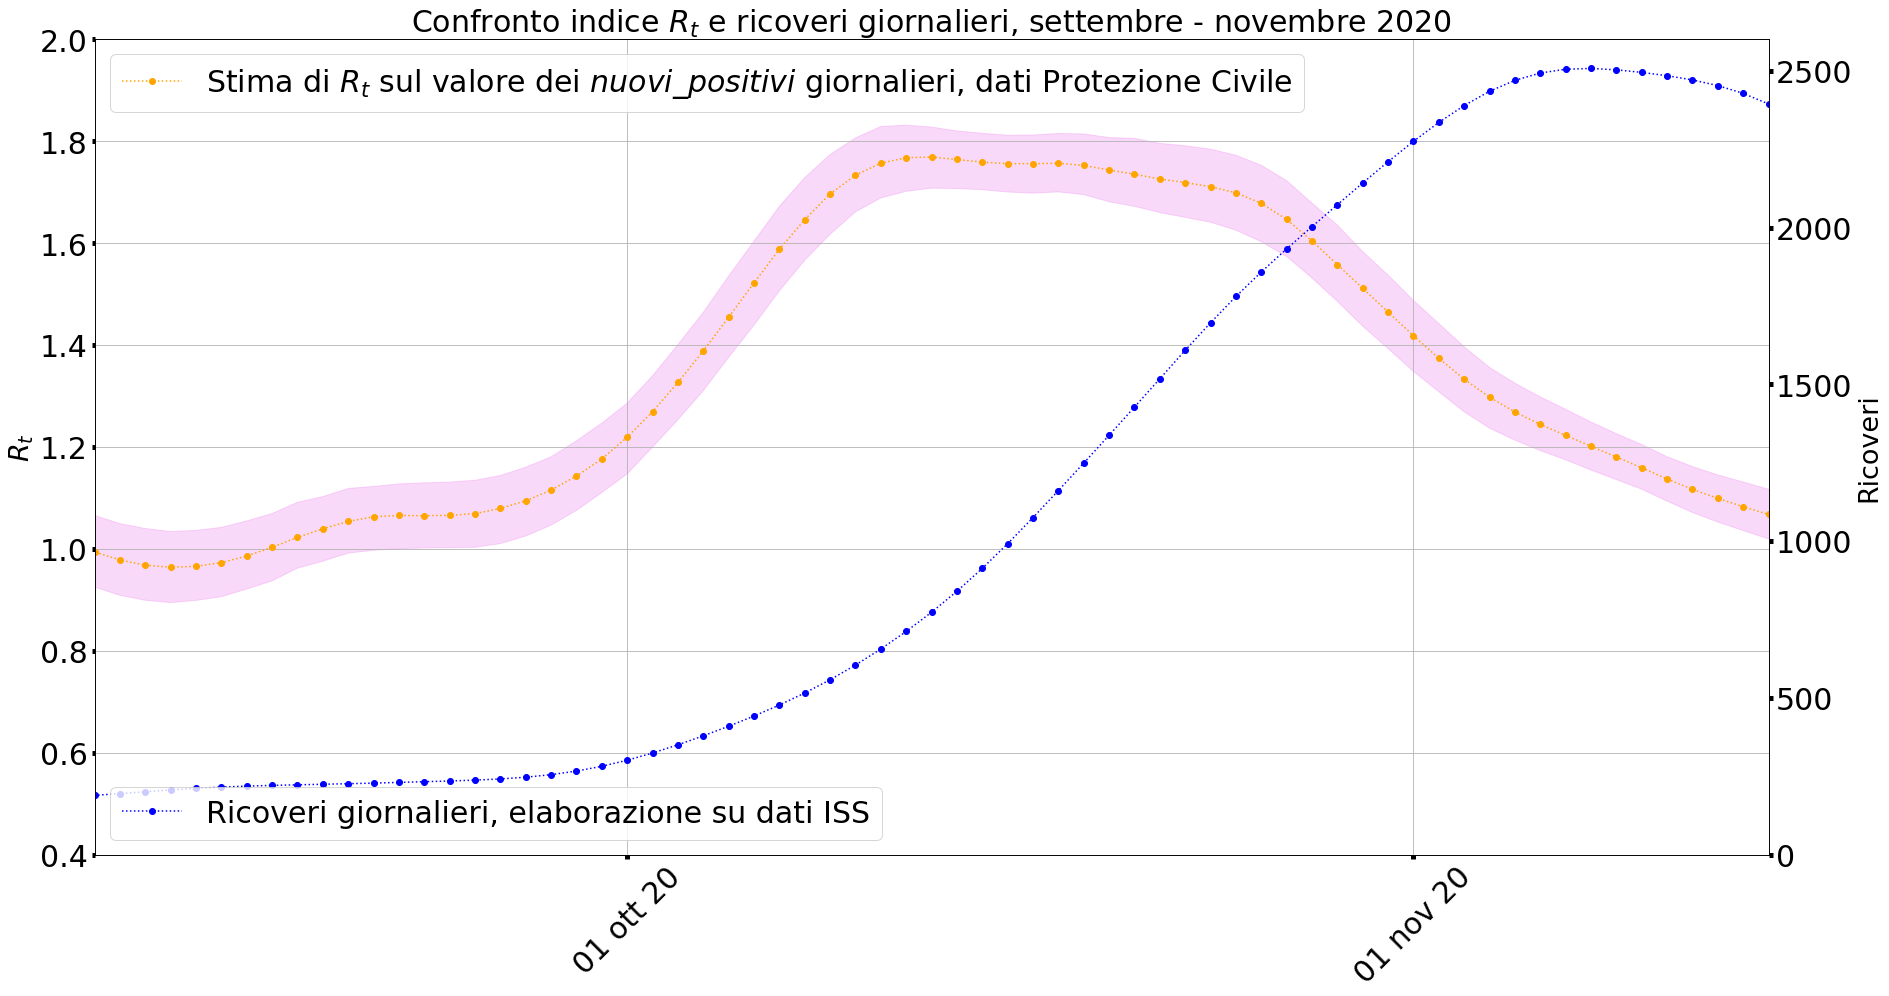

In [33]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, settembre - novembre 2020',
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable,
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2600),
            'secondary_ylabel': "Ricoveri",
            'labels':['Ricoveri giornalieri, elaborazione su dati ISS']
        },        
    ],
    xlim=(datetime(2020,9,10), datetime(2020,11,15)),#DPC_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #ylim=(-10000,40000),
    legend_loc="upper left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_set_nov_2020"),
    dpi=150,
    quality=60
    
)


In [34]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-09-30")&(ricoveri_stable.data<="2020-10-06")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 282.201754589504 442.48558414568475 160.28382955618076 56.79760205223835


In [35]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-06")&(ricoveri_stable.data<"2020-10-13")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 442.48558414568475 712.2575105511585 269.7719264054737 60.9673933053271


In [36]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-13")&(ricoveri_stable.data<"2020-10-20")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 773.4191241124115 1249.0854534691448 475.6663293567333 61.501754291712885


In [37]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-20")&(ricoveri_stable.data<"2020-10-27")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 1337.7941111268 1858.4150628363618 520.6209517095617 38.916373407493325


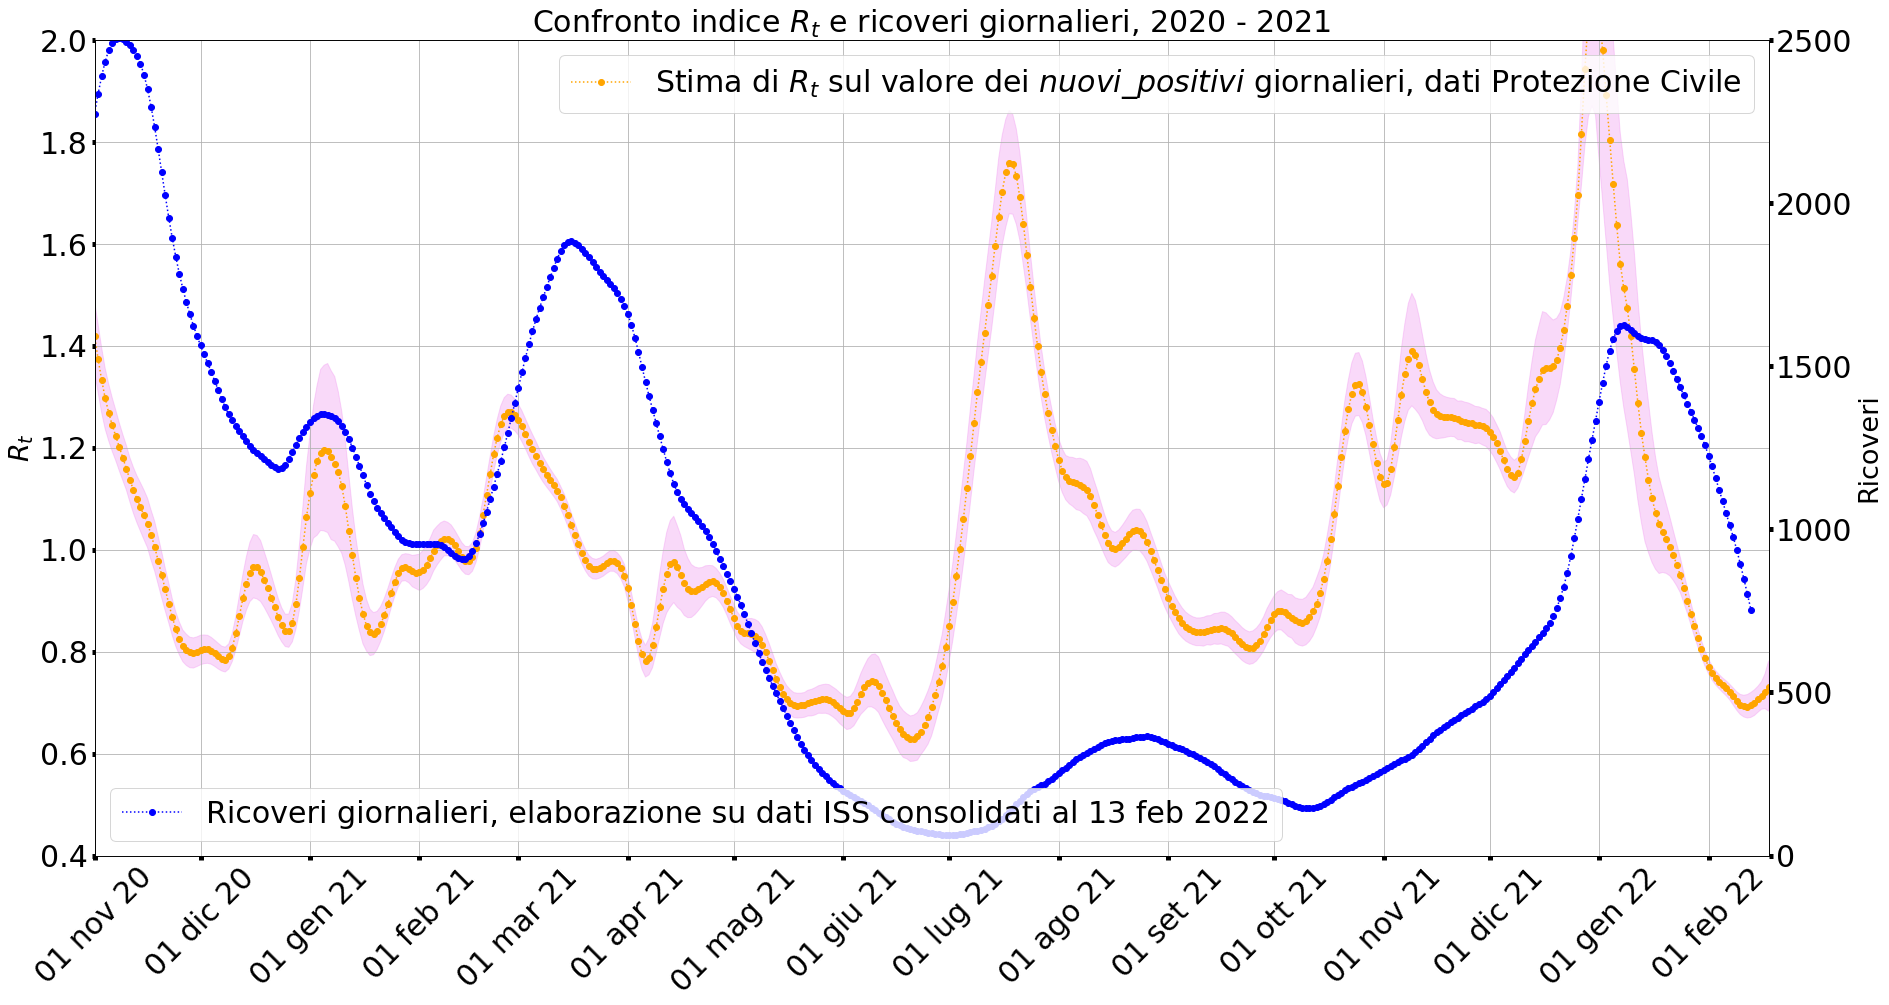

In [38]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, 2020 - 2021',
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%d %b"),    
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable, #ricoveri[ricoveri.data<="2021-07-11"],
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2500),
            'secondary_ylabel': "Ricoveri",
            'labels':[f'Ricoveri giornalieri, elaborazione su dati ISS consolidati al {ricoveri_stable.data.max().strftime("%d %b %Y")}']
        },        
    ],
    xlim=(datetime(2020,11,1), italy_calc_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #tick_fontsize=22,
    #ylim=(-10000,40000),
    legend_loc="upper right",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_2020_2021"),
    dpi=150,
    quality=60,
)


In [39]:
ricoveri_stable[(ricoveri_stable.data<="2022-02-10")&(ricoveri_stable.data>="2022-01-15")]

,iss_date,DATARICOVERO1,RICOVERI,data,RICOVERI_deseason,RICOVERI_deseason_seasonality,RICOVERI_deseason_smoothed,RICOVERI_deseason_residuals,RICOVERI_deseason_relative_residuals,RICOVERI_deseason_smoothed_Rt
695,21/02/2022,15/01/2022,1537,2022-01-15,1653.632185,-116.632185,1581.695179,71.937007,0.045481,1.025979
696,21/02/2022,16/01/2022,1238,2022-01-16,1490.203555,-252.203555,1579.477564,-89.274009,-0.056521,1.019953
697,21/02/2022,17/01/2022,1738,2022-01-17,1632.029345,105.970655,1574.744012,57.285333,0.036378,1.013689
698,21/02/2022,18/01/2022,1784,2022-01-18,1685.369617,98.630383,1565.475440,119.894177,0.076586,1.005694
699,21/02/2022,19/01/2022,1623,2022-01-19,1551.425066,71.574934,1550.792292,0.632774,0.000408,0.995422
700,21/02/2022,20/01/2022,1605,2022-01-20,1533.859374,71.140626,1531.403054,2.456320,0.001604,0.983466
701,21/02/2022,21/01/2022,1494,2022-01-21,1432.994321,61.005679,1508.848807,-75.854487,-0.050273,0.970963
702,21/02/2022,22/01/2022,1396,2022-01-22,1495.648893,-99.648893,1484.755917,10.892976,0.007337,0.959028
703,21/02/2022,23/01/2022,1172,2022-01-23,1407.304934,-235.304934,1460.127661,-52.822727,-0.036177,0.948273
704,21/02/2022,24/01/2022,1574,2022-01-24,1483.586140,90.413860,1435.457704,48.128437,0.033528,0.938901


In [40]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-11")&(ricoveri_stable.data<"2021-07-18")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 82.407116137787 123.12295364241548 40.71583750462848 49.40815722340103


In [41]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-18")&(ricoveri_stable.data<"2021-07-24")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(6, 10) 134.00206071202422 188.4769364520675 54.474875740043274 40.652267174541414


In [42]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 196.72867770181284 235.0824425583996 38.353764856586764 19.495767116739653


In [43]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-09")&(ricoveri_stable.data<"2021-08-16")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 315.35180471917784 348.0216491825163 32.66984446333845 10.359808941772537


In [44]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-14")&(ricoveri_stable.data<"2021-07-21")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 97.18592338451919 157.02517228113058 59.839248896611394 61.5719301856664


In [45]:
filt=ricoveri_stable[(ricoveri_stable.data>"2021-07-16")&(ricoveri_stable.data<="2021-07-23")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 123.12295364241548 188.4769364520675 65.35398280965201 53.080259103805126


In [46]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 196.72867770181284 235.0824425583996 38.353764856586764 19.495767116739653


In [47]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-20")&(ricoveri_stable.data<="2021-09-04")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(16, 10) 330.18705317711107 365.1526697402033 34.965616563092226 10.589638880945705
